In [226]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.graph_objects as go
from functools import partial, reduce
import benchmarks
from typing import List, Tuple, Callable

Function to optimize :  eggholder
Dimension :  2
Search space :  [-512, -512] [512, 512]


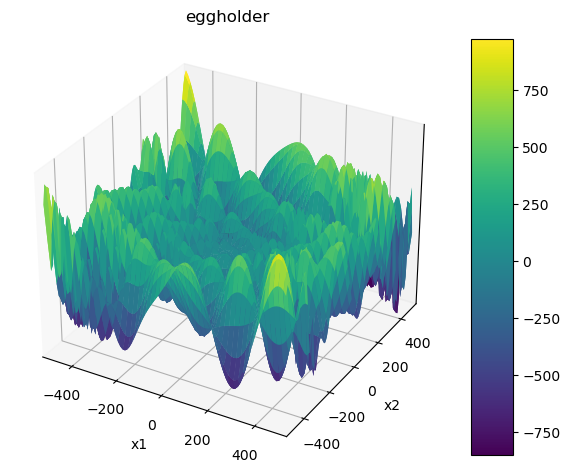

In [227]:
# Evaluation function
FUNCTION = benchmarks.eggholder  # function to optimize

DIM = 2  # problem dimension
# domain of variation definition
INFS, SUPS = benchmarks.get_domain_by_function_name(FUNCTION.__name__, DIM)  # search space

print("Function to optimize : ", FUNCTION.__name__)
print("Dimension : ", DIM)
print("Search space : ", INFS, SUPS)


def viz_3D_function(func, infs, sups, title=""):
    """
    Plot the function in the search space.
    """
    # square figure
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    # plot function
    x = np.linspace(infs[0], sups[0], 100)
    y = np.linspace(infs[1], sups[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([func(np.array([X[i, j], Y[i, j]])) for i in range(X.shape[0]) for j in range(X.shape[1])]).reshape(
        X.shape)

    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    # add range bar on the right
    fig.colorbar(ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none'), ax=ax, shrink=0.9, aspect=10)
    # Plot the swarm (top view)
    ax.set_xlim(infs[0], sups[0])
    ax.set_ylim(infs[1], sups[1])
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_title(title)
    # hide z axis
    ax.set_zticks([])
    plt.show()


viz_3D_function(FUNCTION, INFS, SUPS, title=FUNCTION.__name__)

## Initialization

In [228]:
def init_food_source(dim: int, infs: list, sups: list) -> np.ndarray:
    """
    Initialize a food source.
    """
    return np.random.uniform(infs, sups, size=dim)


def init_food_sources(n, dim, infs, sups):
    """
    Initialize the food sources (population).
    """
    return [init_food_source(dim, infs, sups) for _ in range(n)]


food_sources_test = init_food_sources(10, 2, INFS, SUPS)
food_sources_test

[array([221.41242088, -92.62314461]),
 array([-278.36536465,  240.24784985]),
 array([-236.39907833, -422.03688067]),
 array([ 128.0851196 , -228.19093743]),
 array([-60.07235289, 420.70795308]),
 array([506.70895816, 381.38202851]),
 array([ -26.73204548, -135.66339861]),
 array([ 457.37674015, -394.07076295]),
 array([-460.77812205, -395.0633405 ]),
 array([-304.43750573, -405.62599411])]

Le choix du nombre de sources de nourriture dépend de la complexité de la fonction à optimiser et de la capacité de calcul disponible. En général, il est recommandé de choisir un nombre suffisamment grand de sources de nourriture pour couvrir l'espace de recherche de manière adéquate.

In [229]:
# Sélection de n individus différents de x
def select_n_individuals(population: List[np.ndarray], x: np.ndarray, n: int) -> List[np.ndarray]:
    individuals = []
    if n > len(population):
        raise ValueError("n must be lower than the population size")
    while len(individuals) < n:
        individual = random.choice(population)
        if not np.array_equal(individual, x) and tuple(individual) not in map(tuple, individuals):
            individuals.append(individual)
    return individuals


select_n_individuals(food_sources_test, food_sources_test[0], 1)

[array([ 457.37674015, -394.07076295])]

### Plot the food sources

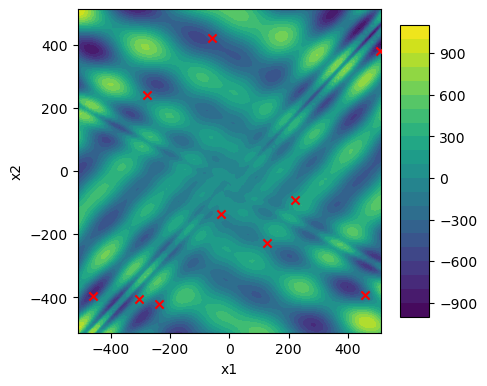

In [230]:
def plot_population(population: list, dim: int, infs: list, sups: list, eval_func=FUNCTION,
                    title: str = "Population", coef_figsize=1):
    """
    Plot the swarm in the search space.
    """
    if (dim > 2):
        print("Plotting is only possible for 2D and 3D problems")
        return

    if (dim == 2):
        # square figure
        fig, ax = plt.subplots(figsize=(7 * coef_figsize, 6 * coef_figsize))
        # plot function
        x = np.linspace(infs[0], sups[0], 100)
        y = np.linspace(infs[1], sups[1], 100)
        X, Y = np.meshgrid(x, y)
        Z = eval_func(np.array([X, Y]))
        ax.contour(X, Y, Z, 20, cmap='viridis', zorder=0)
        # add range bar on the right
        fig.colorbar(ax.contourf(X, Y, Z, 20, cmap='viridis'), ax=ax, shrink=0.9, aspect=10)
        # Plot the swarm (top view)
        ax.set_xlim(infs[0], sups[0])
        ax.set_ylim(infs[1], sups[1])
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title(title, fontsize=26 * coef_figsize)
        # Plot the swarm
        for ind in population:
            ax.scatter(ind[0], ind[1], color="red", s=50 * coef_figsize, zorder=10, marker="x")

    plt.show()


plot_population(food_sources_test, 2, INFS, SUPS, title="", coef_figsize=0.7)

In [231]:
def fitness(x: np.ndarray, func: Callable, is_minimization: bool = True) -> float:
    """
    Return the fitness of an individual.
    """
    if is_minimization:
        return 1 / (1 + func(x)) if func(x) > 0 else 1 + abs(func(x))
    else:
        return func(x)


def is_better(src1: np.ndarray, src2: np.ndarray, func: Callable) -> bool:
    """
    Return True if ind1 is better than ind2.
    """
    return fitness(src1, func) > fitness(src2, func)


def max_source(src1: np.ndarray, src2: np.ndarray, func: Callable) -> np.ndarray:
    """
    Return the best individual between ind1 and ind2.
    """
    if is_better(src1, src2, func):
        return src1
    else:
        return src2


is_better(food_sources_test[0], food_sources_test[1], FUNCTION)

False

In [232]:
def get_best_source(population: List[np.ndarray], func: Callable) -> Tuple[np.ndarray, float]:
    """
    Return the best individual
    """
    return reduce(partial(max_source, func=func), population)


tmp = get_best_source(food_sources_test, FUNCTION)
print(">>> Best source:", tmp, "with fitness:", fitness(tmp, FUNCTION))
# al fitnesses
np.array([fitness(x, FUNCTION) for x in food_sources_test])

>>> Best source: [-460.77812205 -395.0633405 ] with fitness: 736.3604332201832


array([5.66205107e-03, 1.61240161e+02, 2.50275914e+02, 5.74378018e+01,
       4.61362780e+02, 6.31500022e+02, 2.97586342e+01, 3.05367843e+02,
       7.36360433e+02, 1.57309379e-02])

## Operators

In [233]:
food_sources_test[-1]

array([-304.43750573, -405.62599411])

In [234]:

def get_probabilities(fitnesses):
    return np.array(fitnesses) / np.sum(fitnesses)


def random_choice(population: List[np.ndarray], probas: List[float]) -> np.ndarray:
    idx = np.random.choice(len(population), p=probas)
    #print(idx,probabilities[idx])
    return population[idx], idx


fitnesses = list(range(len(food_sources_test)))
probabilities = get_probabilities(fitnesses)
random_choice(food_sources_test, probabilities)

(array([-278.36536465,  240.24784985]), 1)

In [235]:
def generate_neighbor(x, other_x):
    x_neighbor = x.copy()
    j = np.random.randint(x.shape[0])  # select a random dimension
    phi = np.random.uniform(-1, 1)
    x_neighbor[j] = x[j] + phi * (x[j] - other_x[j])
    #print(f"phi: {phi}, j: {j}")

    #print((x[j] - other_x[j]))
    #print(phi * (x[j] - other_x[j]))
    return x_neighbor

# generate a neighbor with other source and best source
def generate_neighbor_with_best(x, other_x, best_x, C : float = 1.5):
    x_neighbor = x.copy()
    j = np.random.randint(x.shape[0])  # select a random dimension
    phi = np.random.uniform(-1, 1)

    # random float [0,C[
    psi = np.random.uniform(0,  C)
    x_neighbor[j] = x[j] + phi * (x[j] - other_x[j]) + psi * (best_x[j] - x[j])
    #print(f"phi: {phi}, j: {j}")

    #print((x[j] - other_x[j]))
    #print(phi * (x[j] - other_x[j]))
    return x_neighbor


def correct_solution(x: np.ndarray, infs: List[float], sups: List[float]) -> np.ndarray:
    """
    Limit the values in the search space.
    """
    return np.clip(x, infs, sups)


x_test = food_sources_test[0]
print(f"Inital source: {x_test}")
print(f"Other source: {food_sources_test[1]}")
x_neighbor = correct_solution(generate_neighbor(x_test, food_sources_test[1]), INFS, SUPS)
print(f"Neighbor: {x_neighbor}")

Inital source: [221.41242088 -92.62314461]
Other source: [-278.36536465  240.24784985]
Neighbor: [ 221.41242088 -120.52052551]


### Employed bee phase

In [236]:
def foraging_source(x: np.ndarray, sources_population: List[np.ndarray], infs: List[float], sups: List[float],
                    func: Callable,CR=0.1) -> np.ndarray:
    """
    Generate a new solution for the foraging source.
    """
    # Select a random different source than x
    other_x = select_n_individuals(sources_population, x, 1)[0]

    # Generate a new solution and correct it to stay inside the search space
    x_neighbor = correct_solution(generate_neighbor(x, other_x), infs, sups)

    # Check if the new solution is better than the current one
    if is_better(x_neighbor, x, func) or np.random.uniform() < CR:
        return x_neighbor, True  # replace the current solution
    else:
        return x, False  # keep the current solution


print(f"Initial source: {x_test}")
foraging_source(x_test, food_sources_test, INFS, SUPS, FUNCTION)

Initial source: [221.41242088 -92.62314461]


(array([221.41242088, -14.15711791]), True)

In [237]:
def employed_bees_phase(current_population: List[np.ndarray], func: Callable[[np.ndarray], float], infs: List,
                        sups: List, trial_counter: np.ndarray) -> List[np.ndarray]:
    for i, x in enumerate(current_population):
        new_x, is_improved = foraging_source(x, current_population, infs, sups, func)
        current_population[i] = new_x  # replace the current solution
        trial_counter[i] += int(not is_improved)  # if the solution is improved, reset the trial counter

    return current_population, trial_counter


employed_bees_phase(food_sources_test, FUNCTION, INFS, SUPS, np.zeros(len(food_sources_test)))

([array([221.41242088, -68.28537844]),
  array([-278.36536465,  240.24784985]),
  array([-238.49436713, -422.03688067]),
  array([ 128.0851196 , -228.19093743]),
  array([-462.8338809 ,  420.70795308]),
  array([506.70895816, 381.38202851]),
  array([ -26.73204548, -135.66339861]),
  array([ 457.37674015, -394.07076295]),
  array([-460.77812205, -395.0633405 ]),
  array([-234.27191519, -405.62599411])],
 array([0., 1., 0., 1., 0., 1., 1., 1., 1., 0.]))

In [238]:
def onlooker_bees_phase(n_bees: int, current_population: List[np.ndarray], func: Callable[[np.ndarray], float],
                        infs: List,
                        sups: List, trial_counter: np.ndarray) -> List[np.ndarray]:
    """
    Select the best solutions and use them to generate new solutions.
    """
    # n_bees peut être ajusté selon le problème
    fitnesses = [fitness(x, func) for x in current_population]
    probabilities = get_probabilities(fitnesses)

    for i_bee in range(n_bees):
        x, idx = random_choice(current_population, probas=probabilities)

        new_x, is_improved = foraging_source(x, current_population, infs, sups, func)
        current_population[idx] = new_x  # replace the current solution
        trial_counter[idx] += int(not is_improved)  # if the solution is improved, reset the trial counter

    return current_population, trial_counter

### Scout bee phase



In [239]:
def explorer_bees_phase(current_population: List[np.ndarray], dim: int, infs: List[float], sups: List[float],
                        trial_counter: List[int], max_trials: int = 100) -> List[np.ndarray]:
    """
    Replace the sources that have not been improved for a long time (abandoned food sources).
    """
    for i, x in enumerate(current_population):
        if trial_counter[i] >= max_trials:
            current_population[i] = init_food_source(dim=dim, infs=infs, sups=sups)
            trial_counter[i] = 0
    return current_population, trial_counter

Le paramètre max_trials contrôle le nombre maximum de tentatives pour améliorer une source de nourriture qui est abandonnée par les abeilles exploratrices.

Le choix de la valeur de max_trials dépend de la complexité de la fonction à optimiser et du nombre de dimensions de l'espace de recherche. Plus la fonction est complexe et plus l'espace de recherche est grand, plus il peut être nécessaire d'augmenter le nombre de max_trials pour que l'algorithme puisse explorer suffisamment l'espace de recherche.

#### Comment choisir le paramètre max_trials ?

Dans l'algorithme ABC, chaque source est testée une fois pendant la phase de recherche de nourriture (employed bees phase ou onlooker bees phase) ou lors de la phase d'exploration (explorer bees phase).

En moyenne, chaque source est donc testée 2 fois par cycle (une fois pendant la phase de recherche de nourriture et une fois pendant la phase d'exploration).

Le nombre maximum de fois qu'une source est testée dépend du nombre maximal de cycles de l'algorithme et du nombre de fois où une source est sélectionnée pour la phase de recherche de nourriture ou la phase d'exploration. Par exemple, si l'algorithme est exécuté pendant 100 cycles et que chaque source est sélectionnée 5 fois pendant chaque phase, alors le nombre maximum de fois qu'une source est testée est de 100 * 5 * 2 = 1000 fois.

On a alors la formule qui permet de connaitre le nombre d'essai en contion de l'itération et du nombre de source :



## ABC algorithm

In [240]:
def evaluate_cohesion(population: list) -> float:
    """
    Return the average distance between all particles in the population.
    """
    num_particles = len(population)
    total_distance = 0
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            distance = np.linalg.norm(population[i] - population[j])  # euclidean distance
            total_distance += distance
    avg_distance = total_distance / (num_particles * (num_particles - 1) / 2)
    return avg_distance


evaluate_cohesion(food_sources_test)

628.1973581346786

### Plotting functions

In [241]:
def print_solution(best: np.ndarray, func: Callable[[np.ndarray], float]):
    print(f"  point = {best}")
    print(f"  value = {func(best)}")



### Main algorithm

>>> Start ABC algorithm
>>> Parameters :
 * population size : 200
 * dimension : 2
 * function : eggholder
 * max_trials_explorer_bee : 10
 * max_iter : 1000
 * max_iter_no_improvement : 100


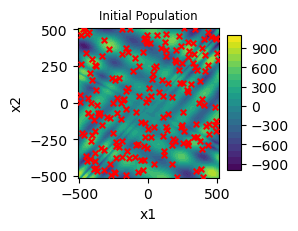

  0%|          | 0/1000 [00:00<?, ?it/s]

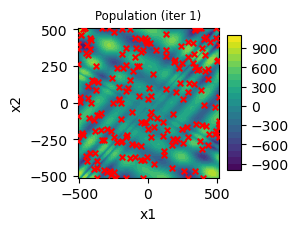

  0%|          | 5/1000 [00:02<06:13,  2.67it/s]

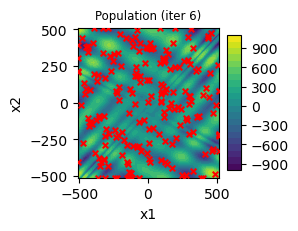

  1%|          | 10/1000 [00:05<06:09,  2.68it/s]

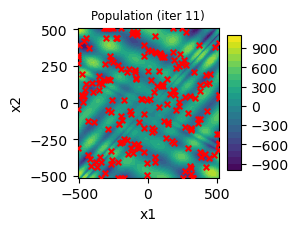

  2%|▎         | 25/1000 [00:10<03:55,  4.14it/s]

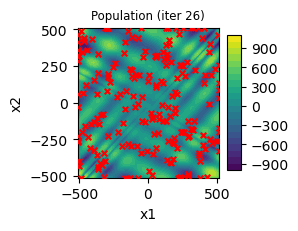

  5%|▌         | 50/1000 [00:19<05:17,  3.00it/s]

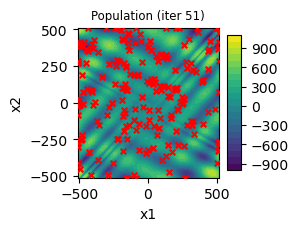

 10%|█         | 100/1000 [00:35<03:17,  4.57it/s]

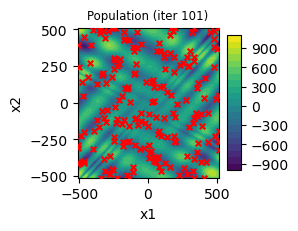

 20%|██        | 200/1000 [01:01<03:14,  4.11it/s]

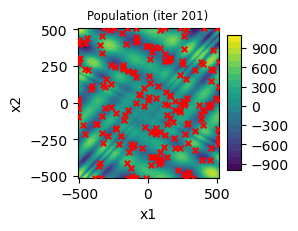

 23%|██▎       | 231/1000 [01:08<03:48,  3.36it/s]

>>> Break : no improvement since 100 iterations


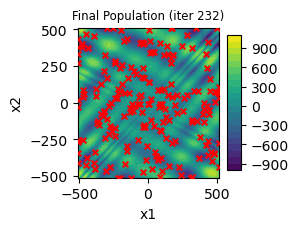

>>> Results after 231 iterations :
> Best solution since the beginning :
  point = [512.         404.53532547]
  value = -959.535723464712
> Best solution at the end :
  point = [-476.40854653  381.66884974]
  value = -867.4835550999865
>>> Display history :


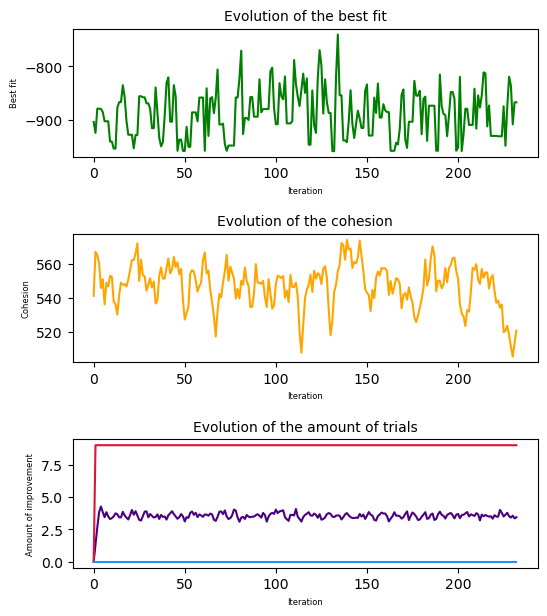

In [250]:

def plot_history(h_best_solution_fit, h_cohesion, h_amount_trials_mean, h_amount_trials_max, h_amount_trials_min,
                 title=""):
    # Plot the evolution of the best fit and cohesion (subplots)

    grid = plt.GridSpec(3, 1,hspace=0.6)
    fig = plt.figure(figsize=(6, 7))
    fig.suptitle(title)

    ax1 = fig.add_subplot(grid[0, :])
    ax1.plot(h_best_solution_fit, color='green')
    ax1.set_title('Evolution of the best fit', fontsize=10)
    ax1.set_xlabel('Iteration', fontsize=6)
    ax1.set_ylabel('Best fit', fontsize=6)

    ax2 = fig.add_subplot(grid[1, :])
    ax2.plot(h_cohesion, color='orange')
    ax2.set_title('Evolution of the cohesion', fontsize=10)
    ax2.set_xlabel('Iteration', fontsize=6)
    ax2.set_ylabel('Cohesion', fontsize=6)

    ax3 = fig.add_subplot(grid[2, :])
    ax3.plot(h_amount_trials_mean, color='indigo', label='Mean of trials')
    ax3.plot(h_amount_trials_max, color='crimson', label='Max of trials')
    ax3.plot(h_amount_trials_min, color='dodgerblue', label='Min of trials')
    ax3.set_title('Evolution of the amount of trials', fontsize=10)
    ax3.set_xlabel('Iteration', fontsize=6)
    ax3.set_ylabel('Amount of improvement', fontsize=6)
    #ax3.grid(color='gray', linestyle='--', linewidth=0.5)

    plt.show()


def ABC_algorithm(pop_size: int, dim: int, func, infs: list, sups: list, max_iter: int = 1000,
                  max_trials_explorer_bee: int = 100,
                  max_iter_no_improvement_best_sol: int = 15, display_iter_population_plots=True,
                  iter_population_plots: list = [], p_max_trials_explorer_bee: int = 0.1, display_history=True,
                  verbose: bool = True):
    #max_trials_explorer_bee = int(pop_size * max_iter * p_max_trials_explorer_bee )
    if verbose:
        print(">>> Start ABC algorithm")
        print(">>> Parameters :")
        print(f" * population size : {pop_size}")
        print(f" * dimension : {dim}")
        print(f" * function : {func.__name__}")
        #print(f" * p_max_trials_explorer_bee : {p_max_trials_explorer_bee}")
        print(f" * max_trials_explorer_bee : {max_trials_explorer_bee}")
        print(f" * max_iter : {max_iter}")
        print(f" * max_iter_no_improvement : {max_iter_no_improvement_best_sol}")

    # initialization of the population
    sources_population = init_food_sources(pop_size, dim, infs, sups)
    plot_population(sources_population, dim, infs, sups, eval_func=func, title=f"Initial Population",
                    coef_figsize=0.325) if display_iter_population_plots else None

    trial_counter = np.zeros(pop_size)
    # init history
    history_sources_population = [sources_population[:]]
    history_best_solution = [get_best_source(sources_population, func)]
    history_cohesion = [evaluate_cohesion(sources_population)]
    history_amount_trials_mean = [trial_counter.mean()]
    history_amount_trials_max = [trial_counter.max()]
    history_amount_trials_min = [trial_counter.min()]
    if verbose:
        range_iter = tqdm(range(max_iter))
    else:
        range_iter = range(max_iter)

    iter_no_improvement = 0

    for num_iter in range_iter:
        # * Employed bees flight *
        sources_population, trial_counter = employed_bees_phase(sources_population, func, infs, sups, trial_counter)
        # * Onlooker bees flight *
        sources_population, trial_counter = onlooker_bees_phase(n_bees=pop_size, current_population=sources_population,
                                                                func=func, infs=infs, sups=sups,
                                                                trial_counter=trial_counter)

        # * Explorer bees phase *
        sources_population, trial_counter = explorer_bees_phase(current_population=sources_population, dim=dim,
                                                                infs=infs, sups=sups, trial_counter=trial_counter,
                                                                max_trials=max_trials_explorer_bee)

        # get the best solution
        best_solution = get_best_source(sources_population, func)
        best_since_beginning = get_best_source(history_best_solution, func)

        # historization
        history_sources_population.append(sources_population[:])
        history_best_solution.append(best_solution)
        history_amount_trials_mean.append(trial_counter.mean())
        history_amount_trials_max.append(trial_counter.max())
        history_amount_trials_min.append(trial_counter.min())
        history_cohesion.append(evaluate_cohesion(sources_population))

        # plot the swarm
        plot_population(sources_population, dim, infs, sups, eval_func=func, title=f"Population (iter {num_iter + 1})",
                        coef_figsize=0.325) if num_iter in iter_population_plots and display_iter_population_plots else None

        # check if no improvement since a while
        if not is_better(best_solution, best_since_beginning, func):
            iter_no_improvement += 1
            #print(f">>> No improvement since {iter_no_improvement} iterations")
            if iter_no_improvement >= max_iter_no_improvement_best_sol:
                if verbose:
                    print(f">>> Break : no improvement since {max_iter_no_improvement_best_sol} iterations")
                break
        else:
            iter_no_improvement = 0

    # final plot
    plot_population(sources_population, dim, infs, sups, eval_func=func,
                    title=f"Final Population (iter {num_iter + 1})",
                    coef_figsize=0.325) if display_iter_population_plots else None

    # get the best solution since the beginning and at the end
    best_since_beginning = get_best_source(history_best_solution, func)
    best_at_end = get_best_source(sources_population, func)
    # display result
    if verbose:
        print(">>> Results after", num_iter, "iterations :")
        print("> Best solution since the beginning :")
        print_solution(best_since_beginning, func)
        print("> Best solution at the end :")
        print_solution(best_at_end, func)

    # display history
    if display_history:
        print(">>> Display history :")
        plot_history([func(x) for x in history_best_solution], history_cohesion, history_amount_trials_mean,
                     history_amount_trials_max, history_amount_trials_min)

    return {
        "best_since_beginning": best_since_beginning,
        "best_at_end": best_at_end,
        "history_best_solution": history_best_solution,
        "history_cohesion": history_cohesion,
        "history_sources_population": history_sources_population,
        "history_amount_trials_mean": history_amount_trials_mean,
        "history_amount_trials_max": history_amount_trials_max}


_ = ABC_algorithm(pop_size=200, dim=DIM, func=FUNCTION, infs=INFS, sups=SUPS, max_iter=1000,
                  max_iter_no_improvement_best_sol=100, max_trials_explorer_bee=10,
                  iter_population_plots=[0, 5, 10, 25, 50, 100, 200], verbose=True)

Après avoir executer le code avec un max_trials_explorer_bee très grand on remarque que dans le graphique du bas que l'amount de trials ne fait qu'augmenter juska la fin de l'algorithme. L'exploitation des sources est donc très mauvaise, voir nulle.

In [248]:
-959.602728374566 < -959.3980774861523

True

## Todo

Demander au prof comment choisir les paramètres de l'algorithme (max_trials_explorer_bee, max_iter_no_improvement_best_sol, max_iter, ...)